In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [10, 5]

# Problem description
>You are a gamer in a FIFA competition. The competition is a fantasy-based league, where you bid for a squad of 22 players. Every player is available for the auction until they’ve been sold. In other words, once a player is selected in/sold to a team, they can’t be bought by another team. Given there’s a salary cap to be decided closer to the auction, how would you prepare and prioritise in selecting the 22 players in your squad?

In [82]:
fifadata = pd.read_csv('data/data.csv')

In [83]:
# Pre-process to Convert Currency
def currency_to_float(cval, currency = '€'):
    """
    Converts currency values into float data types
    Arguments:
        cval: a currency encoded string value e.g. '60K' or '118.5M'
        currency: the currency to convert from defaults to '€'
    Returns:
        float value representation of the data
    Example:
        currency_to_float('20.5M')
    """
    # replaces the euro symbol
    cval = cval.replace(currency,'')
    if 'M' in cval:
        cval = cval.replace('M','')
        cval = float(cval) * (10**6)
    elif 'K' in cval:
        cval = cval.replace('K','')
        cval = float(cval) * (10**3)
    else:
        cval = float(cval)
    return(cval)

fifadata['Value_converted'] = fifadata.Value.apply(currency_to_float)

In [84]:
# Deprecated diagnostic plots
# sns.distplot(fifadata.Overall)
# sns.distplot(fifadata.Value_converted)
#sns.distplot(fifadata.Value_converted[fifadata.Value_converted > 0] )

## Exploring Data

Focusing on the relationship between overall rating & player cost (used a proxy for salary cap here) indicates that well ranked players are paid the most however the relationship is not linear.

Note that the graph below is for all 18207 players in the dataset. There is a non linear monotonically increasing relationship between overall rating and player value i.e. you get what you pay for.


C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


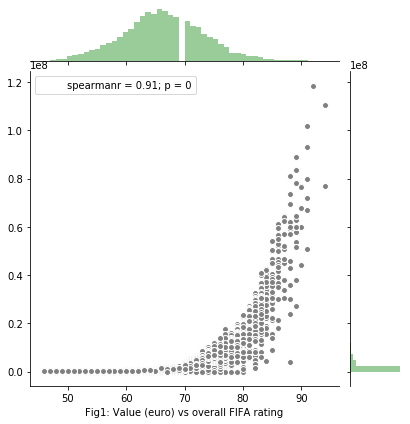

In [85]:
# Code for plot of converted value vs overall rating
from scipy import stats
correlation = fifadata['Value_converted'].corr(fifadata.Overall
                                                , method = 'spearman')
#fig, ax = sns.jointplot(fifadata.Overall, fifadata.Value_converted)
g = sns.JointGrid(x="Overall", y="Value_converted", data=fifadata)
g = g.plot_joint(plt.scatter, color=".5", edgecolor="white")
g = g.plot_marginals(sns.distplot, kde=False, color="g")
g = g.annotate(stats.spearmanr)
g = g.set_axis_labels('Fig1: Value (euro) vs overall FIFA rating')
#g.set_title('Value (euro) vs overall FIFA rating')

How are FIFA ratings calculated:
- 300 human editors watch real matches and try and quantify ratings
- ratings are artifically adjusted to meet real world performance (despite low attributes) and are adjusted upwards
- teams / leagues affect how the player is rated
- ratings are affected by real world salaries
- FIFA rankings do not affect gameplay, only player stats affect gameplay

Key takeaway is ratings are generally correct and player valuations are inflated at the top end of the rating range. **Since ratings alone are not useful  for player performance we need to figure out what player features (such as aggression or ball control) are useful for picking out good players**.

https://www.vg247.com/2016/09/27/how-ea-calculates-fifa-17-player-ratings/

http://www.espn.com.au/football/blog/espn-fc-united/68/post/2959703/fifa-17-player-ratings-system-blends-advanced-stats-and-subjective-scouting

# Breakdown of Overall Rating by position
To understand the rating system lets have a look at the rating by position. Please note that we're removing the 0 Euro players and players without positions.

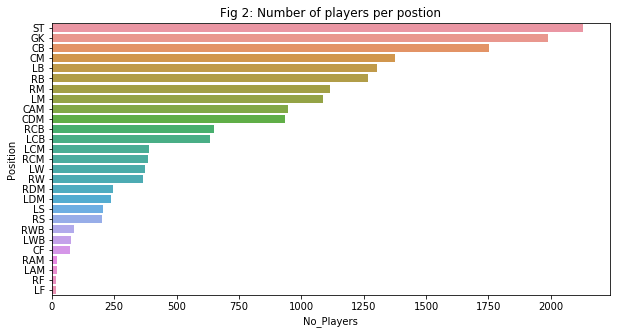

In [86]:
# Code to generate position counts
fifadata_cleaned = fifadata[fifadata.Position.notna() & fifadata.Value_converted > 0] 
positiondf = fifadata_cleaned.Position.value_counts().rename_axis('Position').reset_index(name='No_Players')
g =sns.barplot( positiondf.No_Players ,positiondf.Position)
g =g.set_title('Fig 2: Number of players per postion')

These positions can be broken down by higher level groupings of positions on the pitch and some may be interchangable. 

In [87]:
# Group positions by position on pitch
position = list(positiondf.Position)
pitch_position = ['Forward','Goal'
                  ,'Defense','Mid','Defense'
                  ,'Defense','Wing','Wing','Mid','Mid','Defense'
                  ,'Defense','Mid','Mid','Wing','Wing','Mid','Mid'
                  ,'Forward','Forward','Defense','Defense','Forward'
                  ,'Mid','Mid','Wing','Wing']
positiondict = dict(zip(position ,pitch_position))

fifadata_cleaned['Pitch_Position']= fifadata_cleaned.Position.apply(lambda x: positiondict[x])

C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Fig 3: Pitch postion vs value (euro) ')

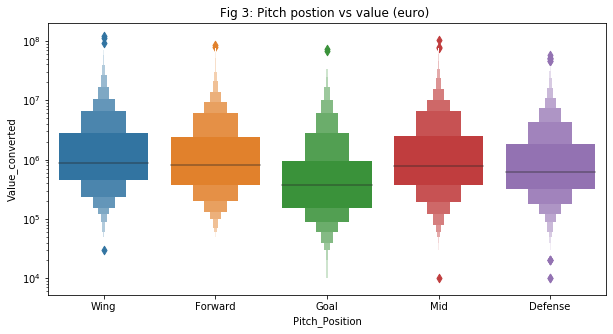

In [88]:
# Code to generate position vs value plots
f, ax = plt.subplots()
ax.set_yscale("log")

sns.boxenplot('Pitch_Position' 
              ,'Value_converted'
              ,   data = fifadata_cleaned)
ax.set_title('Fig 3: Pitch postion vs value (euro) ')

Text(0.5, 1.0, 'Fig 4: Pitch postion for Goal and Wing vs value (euro) ')

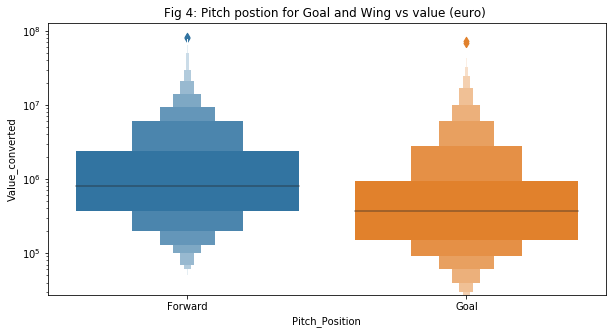

In [89]:
# Code to generate position vs value plots for Wing and Goal


f, ax = plt.subplots()
ax.set_yscale("log")
sns.boxenplot("Pitch_Position"
              , "Value_converted"
              , data =fifadata_cleaned[fifadata_cleaned.Pitch_Position.isin(['Forward','Goal'])])
ax.set_title('Fig 4: Pitch postion for Goal and Wing vs value (euro) ')
#ax.annotate(t_test_msg,xy=(2, 1))


In [90]:
# RUN a t test
from scipy.stats import ttest_ind, ttest_ind_from_stats
fwdvalue = fifadata_cleaned[fifadata_cleaned.Pitch_Position == 'Forward']['Value_converted']
goalvalue = fifadata_cleaned[fifadata_cleaned.Pitch_Position == 'Goal']['Value_converted']

t, p = ttest_ind(fwdvalue, goalvalue, equal_var=False)
t_test_msg = "ttest_ind: t = "+str(t) +" p = " + str(p)
# p value is < alpha therefore we reject the null hyp


C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 1.0, 'Fig 5: Pitch postion vs rating to cost ratio ')

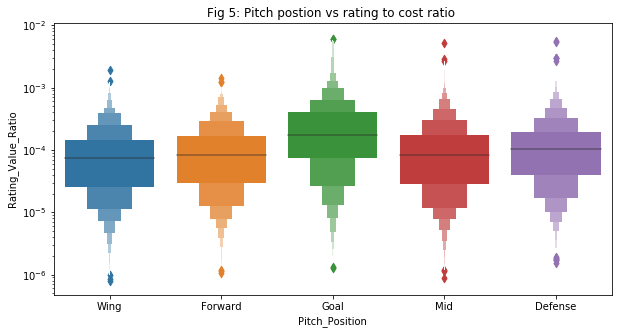

In [91]:
# Rating ratio by positions
fifadata_cleaned ['Rating_Value_Ratio'] = fifadata_cleaned.Overall/fifadata_cleaned.Value_converted

f, ax = plt.subplots()
ax.set_yscale("log")
sns.boxenplot("Pitch_Position"
              , "Rating_Value_Ratio"
              , data =fifadata_cleaned)
ax.set_title('Fig 5: Pitch postion vs rating to cost ratio ')


From Figures 3-5 we should treat model the different positions differently in order to maximize value (measured by the rating to cost ratio)

In order to establish a baseline the provided FIFA data was combined with Soccer ranking data from [fivethirtyeight](https://projects.fivethirtyeight.com/global-club-soccer-rankings/)

Seen below are the top 20 clubs and their respective mean overall ratings

In [92]:
# get club ranking table
fifaclub_overall = fifadata_cleaned.groupby('Club') \
.agg({'Overall': ['mean'] 
      , 'International Reputation':['mean']
       , 'Value_converted':['mean']
     }) \
.reset_index()

fifaclub_overall.columns = [' '.join(col) for col in fifaclub_overall.columns]
spi_ranking = pd.read_csv('data/spi_global_rankings.csv')




def sanitize_club_name(clubnames):
    """
    Sanitizes the club names to improve match rates by lowering case and removing white spaces
    Args:
        clubnames( pd.Series): A pandas series consisting of the club names
    Returns:
        clubnames (pd.Series): the sanitized list
    """
    clubnames = clubnames.lower()
    clubnames = clubnames.rstrip()
    clubnames = clubnames.lstrip()
    clubnames = clubnames.replace('fc','')
    clubnames = clubnames.replace('salonika','')
    clubnames = clubnames.replace('münchen','munich')
    return(clubnames)

spi_ranking.name = spi_ranking.name.apply(sanitize_club_name)
fifaclub_overall['Club '] =fifaclub_overall['Club '].apply(sanitize_club_name)





# ranked_clubs = pd.merge(spi_ranking
#          , fifaclub_overall
#          , left_on = 'name'
#          , right_on = 'Club '
#          , how = 'left'
#      )

from fuzzymatcher import link_table
import fuzzymatcher

ranked_clubs = fuzzymatcher.fuzzy_left_join(spi_ranking
         , fifaclub_overall
         , left_on = 'name'
         , right_on = 'Club ')

ranked_clubs = ranked_clubs.dropna()


# ranked_clubs.columns

ranked_clubs.columns = ['best_match_score', '__id_left', '__id_right', 'rank', 'prev_rank',
       'name', 'league', 'off', 'def', 'spi', 'Club', 'Overall_rating_mean',
       'International_Reputation_mean', 'Player_value_mean' ]


ranked_clubs[['name','Overall_rating_mean',
              'Player_value_mean','spi','rank']] \
.head(20)

,name,Overall_rating_mean,Player_value_mean,spi,rank
0,manchester city,76.727273,2.383500e+07,94.39,1
1,bayern munich,77.000000,2.341466e+07,93.50,2
2,liverpool,76.000000,1.772894e+07,92.98,3
3,barcelona,78.030303,2.583636e+07,91.74,4
4,paris saint-germain,77.433333,2.084417e+07,85.66,5
5,chelsea,76.787879,1.838833e+07,85.06,6
6,real madrid,78.242424,2.649773e+07,84.54,7
7,atletico madrid,75.060606,1.953106e+07,84.19,8
9,olympiacos,72.500000,4.714286e+06,83.35,9
10,ajax,73.633333,8.428333e+06,82.85,10


Below are the top Overall ranked players for each position

In [93]:
# top players by position
fifadata_cleaned \
.groupby('Pitch_Position') \
.apply(lambda x: x.sort_values(["Overall"] , ascending=False)) \
.reset_index(drop=True) \
.groupby('Pitch_Position').head(1) \
[['Name', 'Overall','Club','Nationality', 'Pitch_Position']]

,Name,Overall,Club,Nationality,Pitch_Position
0,Sergio Ramos,91,Real Madrid,Spain,Defense
5775,Cristiano Ronaldo,94,Juventus,Portugal,Forward
8386,De Gea,91,Manchester United,Spain,Goal
10375,K. De Bruyne,91,Manchester City,Belgium,Mid
14937,L. Messi,94,FC Barcelona,Argentina,Wing


# Niave Model 

Configurations of soccer teams can depend on many factors including favored attack/defense, team loyalty and leagues. 

For the rest of this analysis the top rated players will be selected. This dataset will be used to select **which players are good deals for their given position**. Put another way this analysis is to select the players with the best ROI.

There is no agreed on best approach to filling out a roster. This meodel allows fantasy league players to choose FIFA players on preferred configurations to maximize their ROI and understand player trade-offs. The suggested use case would be to build the majority of the squad on a budget and use remainder of allowed fantasy money to bid on star platers.

## Assumptions:
- Fifa overall ranking will be the determining factor for deciding on a player
- Specific position considerations will be ignored
- Teams/leagues will be ignored
- Player Values ar the best way or predicting the auction value

## Process
For each pitch position
- Down select data (Ranking > 75  & by pitch position)
- Fit an XGboost model to the scaled ratio of rating with player features (try and negate inflation of player worth and rating at higher rating levels).
- Use the important variables to fit a kmeans for clustering
- Use the clustering to find the most value for money players ,sorting the top 15 remaining percent and ordering by cost ratio


C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Fig 6: Scaled rating to cost ratio ')

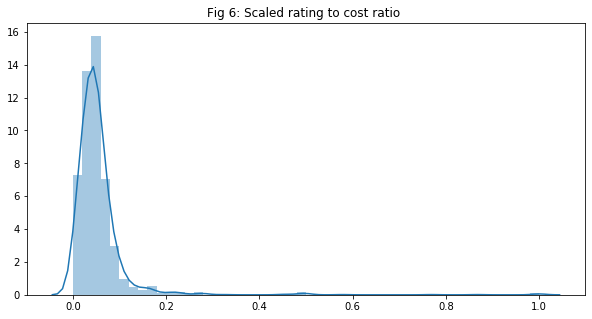

In [94]:
# Down selecting  and creating scaled ratio
from sklearn import preprocessing
original = fifadata_cleaned 
fifadata_cleaned = fifadata_cleaned[fifadata_cleaned.Overall >= 75 ]
fifadata_cleaned['ratingratio'] = fifadata_cleaned['Overall']/fifadata_cleaned.Value_converted

min_max_scaler = preprocessing.MinMaxScaler()
x = fifadata_cleaned[['ratingratio']].values
scaled_ratio = min_max_scaler.fit_transform(x)
fifadata_cleaned['scaled_rating_ratio'] = scaled_ratio
f, ax = plt.subplots()
sns.distplot(scaled_ratio)
ax.set_title('Fig 6: Scaled rating to cost ratio ')

In [111]:
# utility functions for training
import numpy as np
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

np.random.seed(1337)


player_features = ['Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes',
                   'Age', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type'
                  ]
# Preferred Foot, Work Rate, Body Type

def model_rating(df, pitchposition ,player_features, trainon = 'scaled_rating_ratio'):
    '''
    Trains a model to pickup what features make a good player for a given pitch postion
    Args:
        df (pd.DataFrame): Pandas dataframe containing all the user data
        pitchpos (string): The pitch position to train the model on
        player_features (list of strings): the list to of features to train the model on
        trainon (string): the feature to model
    Returns:
        Trained Xgb model
    '''
    print('training for', trainon)
    param = {'max_depth': 2
             , 'eta': 1
             , 'silent': 1
           }
    param['nthread'] = 4
    param['eval_metric'] = 'rmse'
    df = df[df.Pitch_Position ==pitchposition ]
    Xdata = df[player_features]
    Xdata = pd.get_dummies(Xdata)
    ydata = df[trainon]
    dtrain = xgb.DMatrix(Xdata, label=ydata)
    num_round = 100
    bst = xgb.train(param, dtrain, num_round)
    xgb.plot_importance(bst)
    return(bst)

    


def find_clusters(df, pitchposition , important_variables):
    '''
    Args:
        df (pd.DataFrame): Pandas dataframe containing all the user data
        pitchpos (string): The pitch position to train the model on
        important_variables (list of strings): list of important variables determined by 
        examining output of model_rating
    Returns:
        Scree plot for number of clusters
    '''
    df = df[df.Pitch_Position ==pitchposition ]
    df = pd.get_dummies(df)
    kmeansdata = df[important_variables]
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(kmeansdata)
        Sum_of_squared_distances.append(km.inertia_)
    fig, axs = plt.subplots(ncols=1, nrows=1)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Fig 7: Elbow Method For Optimal k')
    plt.show()
      



def plot_cluster(df, pitchposition , important_variables, k_clusters):
    '''
    Args:
        df (pd.DataFrame): Pandas dataframe containing all the user data
        pitchpos (string): The pitch position to train the model on
        important_variables (list of strings): list of important variables determined by 
        examining output of model_rating 
        nclusters (int) : the number of clusters determined for plotting the pitch position
    Returns:
        dataframe of player clusters along with diagnostic plots
    '''
    df = df[df.Pitch_Position ==pitchposition ]
    

    playerid = df['ID']
    playername = df.Name
    Overall = df['Overall']
    Value_converted = df.Value_converted
    Cost = df.Value_converted.apply(np.log)
    #Score the dataset
    df = pd.get_dummies(df)
    kmeansdata = df[important_variables]
    km = KMeans(k_clusters)
    km = km.fit(kmeansdata)
    pred_classes = km.predict(kmeansdata)
    
    
    pca = PCA(n_components=2)
    plotdata = pca.fit_transform(kmeansdata)
    x  = [pc[0] for pc in plotdata ]
    y  = [pc[1] for pc in plotdata ]
    
    fig, axs = plt.subplots(ncols=1, nrows=3)
    
    sns.scatterplot(x,y,hue=pred_classes,  ax=axs[0])
    
    sns.boxplot(pred_classes, Overall, ax=axs[1])
    sns.boxplot( pred_classes, Cost,  ax=axs[2])
    

    
    player_cluster_allocations = np.array([playerid,Overall ,pred_classes, Value_converted, playername])
    player_cluster_allocations =pd.DataFrame(player_cluster_allocations.T
                                            ,  columns= ['playerid','Overall','pred_classes','Value_converted','playername'] 
                                             , index = range(player_cluster_allocations.shape[1])
                                            )
    return(player_cluster_allocations)

def cluster_comptable(fifadf,  clusterdf,important_variables):
    '''
    Generates the cluster comparison table
    Args:
        fifadf (pd.DataFrame): Pandas dataframe containing all the fifadata
        clusterdf (pd.DataFrame): Pandas dataframe containing all cluster assignments
        important_variables (list of strings): list of important variables determined by 
        examining output of model_rating 
    Returns:
        dataframe of cluster breakdowns
    '''
    colist =def_impvars + ['ID']
    impdataset = pd.get_dummies(fifadf)[colist]
    cluster_feat = clusterdf \
    .merge(impdataset,left_on='playerid' , right_on='ID')

    final_cols = def_impvars + ['pred_classes' ,'Overall','Value_converted']
    dispdf = cluster_feat[final_cols] \
    .groupby('pred_classes') \
    .agg('mean') \
    .style.apply(highlight_max)
    
    return(dispdf)

def cluster_player_plot(clusterdf , topn =85):
    '''
    Create a plot of cluster assignments with the players transposed on it
    Args:
        clusterdf (pd.DataFrame): data frame with clusters assigned to players
        topn (int): the percentile of overall ranking to use for plotting
    Returns:
        Scatter plot of Overall rating vs Value converted for the clustered players
    '''
    plotarea = clusterdf [(clusterdf['Overall'] > np.percentile(clusterassignments['Overall'] , topn)) ]
    plotarea['clusterhue'] = 'cluster_'+clusterdf.pred_classes.apply(lambda x: str(x))
    fig, axs = plt.subplots(ncols=1, nrows=1)
    sns.scatterplot('Overall', 'Value_converted' 
                , hue = 'clusterhue'
                , data =plotarea )

def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    
def get_max_roi_players(cluserdf, percentile , topn=5):
    '''
    Gets the max ROI players per cluster for the percentile specified
    Args:
        clusterdf (pd.dataframe): the dataframe of players with clusters assigned to them
        percentile (int): the percentile for which to look for ROI players
        topn (int) : the number of top ROI players in each category
    Returns:
        pandas dataframe with playerid, Overall Rating, pred_classes , Value_converted , playername and ratingratio
    '''

    clusterassignments['ratingratio'] = clusterassignments['Overall']/clusterassignments.Value_converted

    dispdf = clusterassignments[clusterassignments['Overall'] > np.percentile(clusterassignments['Overall'] , 50)]. \
    groupby('pred_classes') \
    .apply(lambda x: x.sort_values(["ratingratio","Overall"] , ascending=False))  \
    .reset_index(drop=True) \
    .groupby('pred_classes').head(topn)
    
    return(dispdf)

def cluster_diffplot(clusterdf, fifadf, impvars,n_features=-1):
    '''
    Generates plots to show how top n features vary across differing clusters
    Args:
        clusterdf (pd.dataFrame): dataframe with clusster asssignment and playerid
        fifadf (pd.DataFrame): the cleaned fifa dataframe to be used with ID column and player featuress
        impvarss (list) : the list of important variables returned by xgboost
        n_features (int): the number of features to plot, defaults to -1 which indicates all features should be plotted
    '''
    
    fifadiagdata = clusterdf[['playerid']].merge(fifadata_cleaned, left_on='playerid', right_on='ID')
    fifadiagdata = pd.get_dummies(fifadiagdata)
    if n_features == -1:
        n_features = len(impvars)
    diagcolumns = impvars[1:n_features]
    plt.rcParams['figure.figsize'] = [n_features, 5]
    fifadiagdata = fifadiagdata[diagcolumns]
    fifadiagdata['pred_classes'] = clusterassignments.pred_classes
    fig, axs = plt.subplots(ncols=len(diagcolumns), nrows=1)
    for i in range(len(diagcolumns)):
        sns.boxplot(fifadiagdata.pred_classes, fifadiagdata[diagcolumns[i]] , ax=axs[i])
    plt.tight_layout()

## Analysis for Defense

## Modelling the player characteristics that are are useful for finding the scaked rating ratio for players

training for scaled_rating_ratio


C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


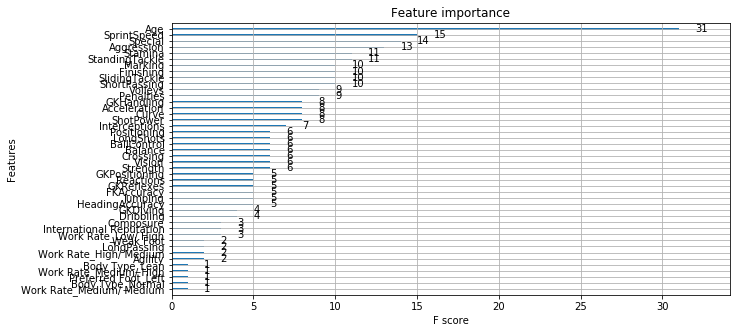

In [112]:
# What are the important variables for a given position
position = 'Defense'
defmod = model_rating(fifadata_cleaned , position, player_features,'scaled_rating_ratio')
def_impvars = list(defmod.get_fscore().keys())


## Creating a diagnostic (screee) plot to model the important player parameters themselves

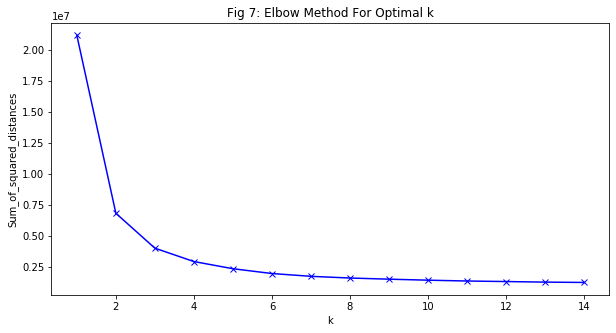

In [113]:
# cluster diagnostic plot
find_clusters(fifadata_cleaned , position , def_impvars)

## Diagnostic plot to relate the playerrs cost and Overall rating per cluster

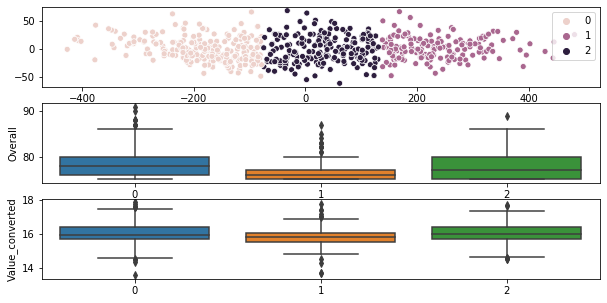

In [114]:
# Cluser diagnostic plots
clusterassignments = plot_cluster(fifadata_cleaned , position, def_impvars, 3)

## Plot to relate the important variables across the clusters

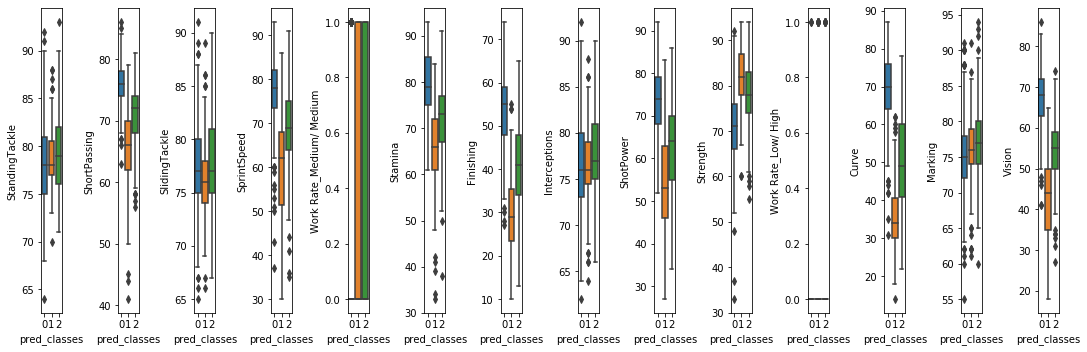

In [119]:
cluster_diffplot(clusterassignments,fifadata_cleaned,def_impvars, 15 )

## Plot showing the spread of the clusters when using Overall Rating vs Cost

C:\Users\New\.virtualenvs\voda-45zESOO9\lib\site-packages\ipykernel_launcher.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


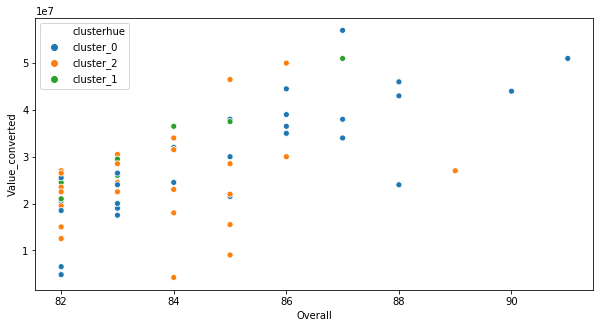

In [116]:
# Plot the top 15% range with cluster and prices
cluster_player_plot(clusterassignments , topn =85)

## Cluster comparison table

In [117]:
# Generating cluster comparison table
cluster_comptable(fifadata_cleaned, clusterassignments,def_impvars )

,Age,StandingTackle,ShortPassing,SlidingTackle,SprintSpeed,Work Rate_Medium/ Medium,Stamina,Finishing,Interceptions,ShotPower,Strength,Work Rate_Low/ High,Curve,Marking,Vision,Agility,Penalties,International Reputation,HeadingAccuracy,Special,Crossing,Aggression,Dribbling,Work Rate_High/ Medium,Balance,BallControl,Jumping,Volleys,FKAccuracy,Acceleration,LongShots,GKReflexes,GKHandling,Positioning,GKDiving,Reactions,LongPassing,GKPositioning,Composure,Body Type_Normal,Preferred Foot_Left,Work Rate_Medium/ High,Weak Foot,Body Type_Lean
pred_classes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,27.636,77.8828,75.9038,77.5439,76.9121,0.205021,79.8745,53.523,76.4268,72.8787,70.887,0.0125523,69.3724,75.1004,66.841,72.9414,57.7531,1.84937,67.9582,2039.68,75.7992,75.4979,73.2887,0.497908,71.4059,75.9749,73.8326,54.841,59.6653,75.8703,64.2385,10.7657,10.4226,66.6067,10.8075,76.6736,70.749,10.4435,73.6946,0.560669,0.460251,0.083682,3.06695,0.368201
1,27.0943,78.7925,65.6981,76.2138,59.1132,0.477987,65.8679,29.9748,76.5975,54.1698,81.9623,0.0880503,35.9748,76.2264,43.1698,50.5157,40.7799,1.46541,77.0377,1632.01,39.9245,77.5472,49.0063,0.0188679,49.5409,61.5409,71.0755,30.8742,33.0692,55.195,34.5157,10.4528,10.1006,33.4025,10.8616,71.8931,60.1069,10.5975,69.7421,0.628931,0.150943,0.289308,2.84906,0.251572
2,27.0508,79.3046,70.7817,77.9442,68.9492,0.370558,71.9746,40.4264,77.4467,62.9188,78.1421,0.0609137,50.1523,77.2386,54.4924,62.2132,48.0812,1.74619,74.9289,1832.86,57.6497,77.9949,61.132,0.167513,60.1827,68.3655,76.3198,39.9594,43.4467,64.7563,46.8376,10.5939,10.6802,47.4365,10.6954,74.2741,66.0152,10.6751,72.0609,0.720812,0.284264,0.329949,2.98477,0.238579


## Table showing the remaining top 50% of players within clusters ranked by their ROI

In [118]:
# determine the best deal in every cluster
get_max_roi_players(clusterassignments, 50 , 5)

,playerid,Overall,pred_classes,Value_converted,playername,ratingratio
0,139997,80,0,1.7e+06,D. Srna,4.70588e-05
1,182744,78,0,2.9e+06,J. Holebas,2.68966e-05
2,230201,79,0,3.6e+06,Maikel Catarino,2.19444e-05
3,108080,79,0,3.6e+06,S. Lichtsteiner,2.19444e-05
4,164082,78,0,4e+06,Adriano,1.95e-05
126,166706,80,1,6e+06,M. Škrtel,1.33333e-05
127,169115,79,1,7e+06,A. Masiello,1.12857e-05
128,214766,78,1,8e+06,C. Izquierdoz,9.75e-06
129,193011,78,1,8.5e+06,S. Cook,9.17647e-06
130,173546,78,1,9e+06,J. Tomkins,8.66667e-06


# Conclusion
Using a Naive model we can assemble a team based on pitch positions:
- This team is priced competitively against the top clubs in the world 
- The team has a compartively similar average rating to the top clubs
- The bulk of a team can be built up with budget players and star players can be bought with left over value

Note that for this model
- At the higher player ratings the model breaks down and is unable to find value

# Potential future work
1. Add more real world and FIFA specific data
1. Model team budgets and configuratioins for specific positions (pitch and granular)
1. Harmonic mean of Potential and Rating
1. Find combinatorial possibilites
1. Position specific modelling

# APPENDIX

In [ ]:
sns.jointplot(fifadata.Potential, fifadata.Value_converted)

## Analysis for Forwards

In [ ]:


# What are the important variables for a given position
position = 'Forward'
defmod = model_rating(fifadata_cleaned , position, player_features,'scaled_rating_ratio')
def_impvars = list(defmod.get_fscore().keys())


# cluster diagnostic plot
find_clusters(fifadata_cleaned , position , def_impvars)

# Cluser diagnostic plots
clusterassignments = plot_cluster(fifadata_cleaned , position, def_impvars, 3)

sns.distplot(clusterassignments.Overall)

# Plot the top 15% range with cluster and prices
cluster_player_plot(clusterassignments , topn =85)


#The table below shows the remaining top 15 percent of players ordered by their rating to cost ratio



In [ ]:
# Generating cluster comparison table
cluster_comptable(fifadata_cleaned, clusterassignments,def_impvars )


In [ ]:
# determine the best deal in every cluster
get_max_roi_players(clusterassignments, 50 , 5)

## Analysis for Goal

In [ ]:
# What are the important variables for a given position
position = 'Goal'
defmod = model_rating(fifadata_cleaned , position, player_features,'scaled_rating_ratio')
def_impvars = list(defmod.get_fscore().keys())


# cluster diagnostic plot
find_clusters(fifadata_cleaned , position , def_impvars)

# Cluser diagnostic plots
clusterassignments = plot_cluster(fifadata_cleaned , position, def_impvars, 3)

sns.distplot(clusterassignments.Overall)

# Plot the top 15% range with cluster and prices
cluster_player_plot(clusterassignments , topn =85)


#The table below shows the remaining top 15 percent of players ordered by their rating to cost ratio


In [ ]:
# Generating cluster comparison table
cluster_comptable(fifadata_cleaned, clusterassignments,def_impvars )


In [ ]:
# determine the best deal in every cluster
get_max_roi_players(clusterassignments, 50 , 5)